<img src="pic.png" width="1000px">

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
import torch.nn as nn
from einops import rearrange
from torchsummary import summary
import torch.optim as optim
import math
from tqdm import tqdm
import cv2
import numpy as np
from torch import Tensor

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu') # TODO: Remove

In [3]:
def calculate_distances(x, y):
    """
    Calculate the euclidean distance between tensors x and y
    x,y dimensions are: (b, c, h, w)
    """
    assert x.shape == y.shape, "x and y must have the same shape"
    assert len(x.shape) == 4, "x and y must have 4 dimensions"
    return torch.sqrt((x - y).pow(2).sum(dim=(1, 2, 3)))

In [4]:
# Test calculate_distance with tensors of shape (b, c, h, w)
x = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8], [9, 7, 6, 5, 4, 3, 2, 1]])
y = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8], [8, 7, 6, 5, 4, 3, 2, 1]])
x = rearrange(x, 'b (c h w) -> b c h w', c=2, h=2, w=2)
y = rearrange(y, 'b (c h w) -> b c h w', c=2, h=2, w=2)
distances = calculate_distances(x, y)
assert distances[0] == 0
assert distances[1] == 1

In [5]:
class VectorQuantizedVariationalAutoencoder(nn.Module):
    def __init__(self, input_dim, codebook_size, encoding_dim, hidden_dim):
        """
        input_dim: dimension of input image: (c, h, w)
        codebook_size: number of codebook vectors
        encoding_dim: encodings dimension: (embedding_size, h, w)
        hidden_dim: hidden dimension of the network, between FC layers
        """
        super(VectorQuantizedVariationalAutoencoder, self).__init__()

        assert len(input_dim) == 3, "Input dimension must be 3D"
        assert len(encoding_dim) == 3, "Encoding dimension must be 3D"

        self.input_dim = input_dim
        self.codebook_size = codebook_size
        self.encoding_dim = encoding_dim
        self.hidden_dim = hidden_dim

        # Unwrap input dimension
        self._input_c = input_dim[0]
        self._input_h = input_dim[1]
        self._input_w = input_dim[2]
        self._input_dim_flat = self._input_c * self._input_h * self._input_w

        # Unwrap encoding dimension
        self._embedding_dim = encoding_dim[0]
        self._encoding_h = encoding_dim[1]
        self._encoding_w = encoding_dim[2]

        # Calculate flat encoding dimension
        self._encoding_dim_flat = self._embedding_dim * self._encoding_h * self._encoding_w

        # Setup components
        self.__setup_encoder()
        self.__setup_decoder()
        self.__setup_codebook()
    
    def __setup_encoder(self):
        self.enc_fc1 = nn.Linear(self._input_dim_flat, self.hidden_dim)
        self.enc_fc2 = nn.Linear(self.hidden_dim, self._encoding_dim_flat)
        self.relu = nn.ReLU()

    def __setup_decoder(self):
        self.dec_fc1 = nn.Linear(self._encoding_dim_flat, self.hidden_dim)
        self.dec_fc2 = nn.Linear(self.hidden_dim, self._input_dim_flat)
        self.sigmoid = nn.Sigmoid()

    def __setup_codebook(self):
        self.codebook = nn.Embedding(self.codebook_size, self._embedding_dim)
        assert self.codebook.weight.requires_grad == True, "Codebook should be learnable"
    
    def encode(self, x):
        assert x.shape[1:] == (self._input_c, self._input_h, self._input_w)

        # Run the layers
        x = rearrange(x, 'b c h w -> b (c h w)') # Flatten the input
        x = self.relu(self.enc_fc1(x))
        x = self.relu(self.enc_fc2(x))

        # Unflatten, last dimension is embedding dim
        x = rearrange(x, 'b (c h w) -> b h w c', c=self._embedding_dim, h=self._encoding_h, w=self._encoding_w)

        return x
    
    def decode(self, z_q) -> Tensor:
        """
        z_q: Quantized encodings of shape (b h w c)

        Returns the reconstructed image x_hat of shape (b c h w)
        """
        # Rearrange so we work on the values, also flatten because of fully-connected layers
        z_q = rearrange(z_q, 'b h w c -> b (c h w)')

        # Run the layers
        x = self.relu(self.dec_fc1(z_q))
        x = self.relu(self.dec_fc2(x))
        x_hat = self.sigmoid(x)

        # Rearrange back to image shape
        x_hat = rearrange(x_hat, 'b (c h w) -> b c h w', c=self._input_c, h=self._input_h, w=self._input_w)

        return x_hat
    
    def calculate_distances(self, z):
        """
        Args:
            z: Input tensor of shape (batch_size, dim_flat)
        Returns:
            distances: Tensor of shape (batch_size, height, width, num_embeddings)
        """
        z = rearrange(z, 'b (c h w) -> (b h w) c', c=self._embedding_dim, h=self._encoding_h, w=self._encoding_w)

        # Z shape: (128, 256)
        # Codebook shape: (512, 256)

        # For each of the 128 vectors in Z, we want to calculate the distance between the vector and all 512 codebook vectors
        # ||z - e||^2 = ||z||^2 + ||e||^2 - 2 * <z,e>
        z_norm_squared = torch.sum(z ** 2, dim=1, keepdim=True)
        e_norm_squared = torch.sum(self.codebook.weight ** 2, dim=1)
        inner_products = torch.matmul(z, self.codebook.weight.t())

        # Distances is of shape (batch, embed_dim)
        distances = z_norm_squared + e_norm_squared - 2 * inner_products
        distances = rearrange(distances, '(b h w) c -> b h w c', b=z.shape[0] // (self._encoding_h * self._encoding_w), h=self._encoding_h, w=self._encoding_w)
        return distances

    def quantize(self, z):
        """
        z_e: (batch_size, encoding_height, encoding_width, embedding_dim)

        Get closest (euclidean distance) codebook vector z_q given z.

        Returns quantized encodings z_q of shape (b h w c)
        """
        assert z.shape[1:] == (self._encoding_h, self._encoding_w, self._embedding_dim)

        flat_input = rearrange(z, 'b h w c -> (b h w) c')

        # TODO: Replace this by my own distances calculation
        # Equation: ||z - e||^2 = ||z||^2 + ||e||^2 - 2 * <z,e>
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
            + torch.sum(self.codebook.weight**2, dim=1)
            - 2 * torch.matmul(flat_input, self.codebook.weight.t()))
        
        #distances = self.calculate_distances(z)

        # Distances is shape (batch, height, width, embed_dim)
        # Get the index of the closest codebook vector
        min_indices = torch.argmin(distances, dim=1)

        # We now have matrix of one-hot vectors, with "1" at the index of the closest codebook vector, given by "min_indices"
        one_hot = nn.functional.one_hot(min_indices, num_classes=self.codebook_size)

        # Now to get the value of the closest codebook vector, we multiply the one-hot matrix with the codebook matrix
        z_q = torch.matmul(one_hot.float(), self.codebook.weight)

        # Reshape back
        z_q = rearrange(z_q, '(b h w) c -> b h w c', b=z.shape[0], h=self._encoding_h, w=self._encoding_w)

        return z_q

    def forward(self, x):
        assert x.shape[1:] == (self._input_c, self._input_h, self._input_w)

        # Encode
        z = self.encode(x)

        # Quantize the latent vector
        z_q = self.quantize(z)

        # Add streight through estimator
        z_q = z + (z_q - z).detach()
        
        # Decode
        x_reconstructed = self.decode(z_q)

        # The output image should have the same shape as the input image
        assert x_reconstructed.shape == x.shape

        # Return x hat (and also some other stuff for loss calculation and debugging)
        return x_reconstructed, z, z_q

# Quantization of z_e

To quantisize the z_e we run `torch.norm()` which calculate length of vector.

For instance if `a = torch.tensor([1, 1])` then the length of vector is `sqrt(1^2 + 1^2) = sqrt(2) = 1.4142`

So we do: `torch.norm(z_e - codebook)` which means we measure distance between two vectors.

Then we apply `argmin`: `torch.argmin(torch.norm(z_e - codebook))` to get the index of the closest vector in the codebook.

Finally we get the quantized vector: `codebook[torch.argmin(torch.norm(z_e - codebook))]`

In [ ]:
# Transformations
# Note: normalizing the images to have values in the range [0, 1] is important for the calculation of BCE loss
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x - x.min()) / (x.max() - x.min()) # Normalize to [0, 1]
])

# Load dataset

# MNIST
# train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# CIFAR-10
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# DataLoader
batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training
num_epochs = 10

# Model
input_dim = (3, 32, 32)
codebook_size = 512

embedding_dim = 64 # Dimension of each codebook vector
encoding_dim = (embedding_dim, 8, 8)

hidden_dim = 1024

model = VectorQuantizedVariationalAutoencoder(input_dim, codebook_size, encoding_dim, hidden_dim).to(device)

# Optimizer
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# # Test distances
# codebook_size = 2
# encoding_dim = (2, 1, 1)
# hidden_dim = 1024
# model = VectorQuantizedVariationalAutoencoder(input_dim, codebook_size, encoding_dim, hidden_dim).to(device)

# # Set embeddings shape (1, 2)
# model.codebook.weight.data = torch.tensor([[1, 2]]).float()
# print(model.codebook.weight.shape)

# # b = 1, c = 1, h = 1, w = 2
# x = torch.tensor([
#     [
#         [
#             [1, 2]
#         ]
#     ]]) 
# x = rearrange(x, '1 1 1 w -> 1 w')
# print(x.shape)
# distances = model.calculate_distances(x)

# # Assert distance
# assert distances[0, 0, 0, 0] == 0
# assert distances[0, 0, 0, 1] == 8

In [8]:
# summary(model, (1, 28, 28))

In [9]:
beta = 0.25 # Scale factor for commitment loss

def loss_function(x, x_hat, z_e, z_q):
    """
    z_e: latent vector before quantization
    z_q: latent vector after quantization
    """
    # TODO: X must be between 0 and 1!
    # Reconstruction loss
    recon_loss = nn.BCELoss(reduction='sum')(x_hat, x)

    # Quantization loss
    quant_loss = nn.functional.mse_loss(z_q, z_e.detach())

    # Commitment loss
    commit_loss = nn.functional.mse_loss(z_q.detach(), z_e)

    # Total loss
    loss = recon_loss + quant_loss + beta * commit_loss

    return loss, recon_loss, quant_loss, commit_loss

In [10]:
def training_step(images, loss_history, recon_loss_history, quant_loss_history, commit_loss_history):
    # Forward pass
    x_hat, z_e, z_q = model(images)

    # Calculate loss
    loss, recon_loss, quant_loss, commit_loss = loss_function(images, x_hat, z_e, z_q)

    # Add all three losses to history
    loss_history.append(loss.item())
    recon_loss_history.append(recon_loss.item())
    quant_loss_history.append(quant_loss.item())
    commit_loss_history.append(commit_loss.item())

    return loss

In [11]:
def train(num_epochs):
    loss_history = []
    quant_loss_history = []
    recon_loss_history = []
    commit_loss_history = []

    for epoch in range(num_epochs):
        model.train()

        overall_loss = 0

        # Use tqdm for progress tracking
        with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]") as t:
            for images, _ in t:
                images = images.to(device)

                assert images.min() >= 0 and images.max() <= 1, "Images must be normalized to [0, 1]"

                # Zero gradients before performing a backward pass
                optimizer.zero_grad() 

                # Perform a forward pass and calculate loss
                loss = training_step(images, loss_history, recon_loss_history, quant_loss_history, commit_loss_history)

                # Add loss to overall loss
                overall_loss += loss.item()

                # Propagate the loss backward
                loss.backward() # Compute gradients (of KL + recon losses)
                optimizer.step() # Adjust weights of the model

        print(f"Epoch [{epoch+1}/{num_epochs}], Recon Loss: {np.mean(recon_loss_history).item():.4f}, KL Loss: {np.mean(quant_loss_history).item():.4f}")
        print("Average loss: ", overall_loss / len(train_loader))

In [12]:
print("Training on device: ", device)
num_epochs = 5
train(num_epochs)

Epoch [1/5]: 100%|██████████| 196/196 [00:47<00:00,  4.13it/s]


Epoch [1/5], Recon Loss: 523617.5181, KL Loss: 0.7795
Average loss:  523618.4915497449


Epoch [2/5]: 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


Epoch [2/5], Recon Loss: 518697.7290, KL Loss: 1.0311
Average loss:  513779.5408163265


Epoch [3/5]: 100%|██████████| 196/196 [00:49<00:00,  3.93it/s]


Epoch [3/5], Recon Loss: 518412.3858, KL Loss: 16.7621
Average loss:  517901.97895408166


Epoch [4/5]: 100%|██████████| 196/196 [00:52<00:00,  3.75it/s]


Epoch [4/5], Recon Loss: 519767.6125, KL Loss: 1923.0159
Average loss:  533385.515226403


Epoch [5/5]: 100%|██████████| 196/196 [00:53<00:00,  3.69it/s]

Epoch [5/5], Recon Loss: 520742.3690, KL Loss: 23730.3357
Average loss:  663340.9151785715


torch.Size([256, 3, 32, 32])
torch.Size([8, 3, 32, 32])


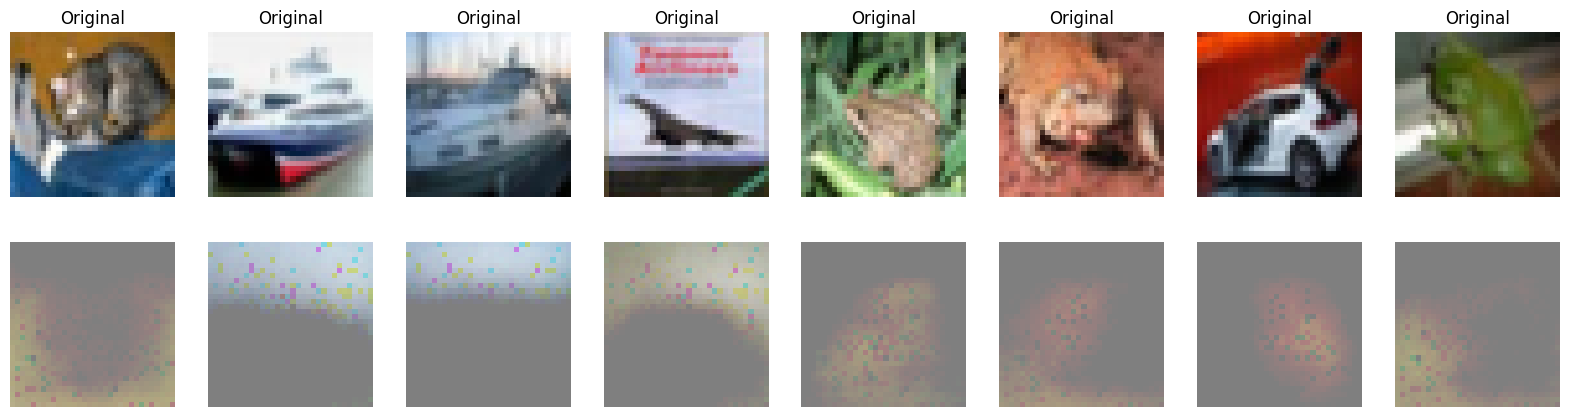

In [ ]:
# Plot 8 images (original image) and to their right plot the reconstructed image
model.eval()
with torch.no_grad():
    images, labels = next(iter(test_loader))
    print(images.shape)
    images = images[:8].to(device)

    outputs, _, _ = model(images)

    images = images.cpu()
    outputs = outputs.cpu()

    print(outputs.shape)

    fig, axes = plt.subplots(2, 8, figsize=(20, 5))
    for i in range(8):
        # Change the order of the channels to (h, w, c) for matplotlib
        axes[0, i].imshow(images[i].permute(1, 2, 0))
        axes[0, i].axis('off')
        # Add title for the image
        axes[0, i].set_title(f"{train_dataset.classes[labels[i]]}")
        axes[1, i].imshow(outputs[i].permute(1, 2, 0))
        axes[1, i].axis('off')

    plt.show()